In [14]:
from ctypes import *
#ctypes.cdll.LoadLibrary('')
lib1 = CDLL("/home/yinglong/Documents/kinodynamic/sparse_rrt/deps/trajopt/build/lib/libsco.so")
lib2 = CDLL("/home/yinglong/Documents/kinodynamic/sparse_rrt/deps/trajopt/build/lib/libutils.so")

In [15]:
from sparse_rrt.planners import SST
from env.cartpole_obs import CartPoleObs
from env.cartpole import CartPole
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd

#obs_list = np.array(obs_list)
system = standard_cpp_systems.CartPole()

bvp_solver = _sst_module.BVPWrapper(system, 4, 1, 24, 0.002)

In [ ]:

#obs_list = np.array(obs_list)
system = standard_cpp_systems.CartPole()
#system = CartPoleObs(obs_list)
# Create SST planner
min_time_steps = 10
max_time_steps = 200
integration_step = 0.002
max_iter = 100000
goal_radius=1.5
random_seed=0
sst_delta_near=2.0
sst_delta_drain=1.2

low = []
high = []
state_bounds = system.get_state_bounds()
for i in range(len(state_bounds)):
    low.append(state_bounds[i][0])
    high.append(state_bounds[i][1])
    
start = np.random.uniform(low=low, high=high)
end = np.random.uniform(low=low, high=high)


start[1] = 0.
start[3] = 0.
end[1] = 0.
end[3] = 0.
planner = SST(
    state_bounds=system.get_state_bounds(),
    control_bounds=system.get_control_bounds(),
    distance=system.distance_computer(),
    start_state=start,
    goal_state=end,
    goal_radius=goal_radius,
    random_seed=0,
    sst_delta_near=sst_delta_near,
    sst_delta_drain=sst_delta_drain
)

    
# Run planning and print out solution is some statistics every few iterations.
time0 = time.time()
for iteration in range(max_iter):
    #if iteration % 50 == 0:
    #    # from time to time use the goal
    #    sample = end
    #    planner.step_with_sample(system, sample, 20, 200, 0.002)
    #else:
    planner.step(system, min_time_steps, max_time_steps, integration_step)
    #    #sample = np.random.uniform(low=low, high=high)
    #print('iteration: %d' % (iteration))
    # interation: 0.002
    #planner.step_with_sample(system, sample, 2, 20, 0.01)
    
    #if iteration % 100 == 0:
solution = planner.get_solution()
print("Solution: %s, Number of nodes: %s" % (planner.get_solution(), planner.get_number_of_nodes()))

print('time spent: %f' % (time.time() - time0))
assert solution is not None

In [3]:
start = np.array([0., 0., 0., 0.])
goal = np.array([5, 0., np.pi, 0.])
solution = bvp_solver.solve(start, goal, 100)
print(solution)


('SCO_ITERATION_LIMIT', array([[-2.18814189e-01, -8.86326569e-03,  2.42732202e-02,
         4.67190052e-04],
       [ 7.51206750e-02, -3.91446086e-02,  8.60202806e-02,
        -7.29119505e-03],
       [ 2.36246698e-01, -7.68822878e-02,  1.66960877e-01,
        -2.34114084e-02],
       [ 4.16992137e-01, -1.20447730e-01,  2.71508070e-01,
        -4.09772424e-02],
       [ 5.98485810e-01, -1.54485431e-01,  3.79313761e-01,
        -6.10514332e-02],
       [ 7.84721438e-01, -1.87710673e-01,  4.97614520e-01,
        -1.10212078e-01],
       [ 9.80965349e-01, -2.25217802e-01,  6.18304343e-01,
        -1.59382918e-01],
       [ 1.21647340e+00, -2.65134738e-01,  7.53915869e-01,
        -2.04982182e-01],
       [ 1.59519810e+00, -3.37089673e-01,  9.71836137e-01,
        -2.75518824e-01],
       [ 1.94501526e+00, -3.95980681e-01,  1.17749266e+00,
        -3.38412932e-01],
       [ 2.07598126e+00, -4.09047214e-01,  1.27044209e+00,
        -3.71005771e-01],
       [ 2.18856078e+00, -4.21667767e-01,

In [4]:
status, states, actions, times = solution
print(states.shape)
print(actions.shape)

(24, 4)
(23, 1)


In [12]:
# visualize the path
"""
Given a list of states, render the environment
"""
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from visual.visualizer import Visualizer



class CartPoleVisualizer(Visualizer):
    def __init__(self, system, params):
        super(CartPoleVisualizer, self).__init__(system, params)
        self.dt = 0.05

    def _init(self):
        # clear the current ax
        ax = plt.gca()
        ax.clear()
        # add patches
        state = self.states[0]
        self.pole = patches.Rectangle((state[0]-self.params['pole_w']/2,self.params['cart_h']),\
                                       self.params['pole_w'],self.params['pole_l'],\
                                      linewidth=.5,edgecolor='red',facecolor='red')
        self.cart = patches.Rectangle((state[0]-self.params['cart_w']/2,0),\
                                       self.params['cart_w'],self.params['cart_h'],\
                                      linewidth=.5,edgecolor='blue',facecolor='blue')
        self.recs = []
        self.recs.append(self.pole)
        self.recs.append(self.cart)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.pole.set_transform(t)
        ax.add_patch(self.pole)
        ax.add_patch(self.cart)
        return self.recs
    def _animate(self, i):
        ax = plt.gca()
        ax.set_xlim(-40, 40)
        ax.set_ylim(-20, 20)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['pole_w']/2,self.params['cart_h']))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)
        self.recs[1].set_xy((state[0]-self.params['cart_w']/2,params['cart_h']))
        # print location of cart
        return self.recs


 
    def animate(self, states, actions, times, obstacles):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''
        # transform the waypoint states and actions into trajectory
        traj = []
        for i in range(len(states)-1):
            print('state: %d, remaining: %d' % (i, len(states)-i))
            s = states[i]
            action = actions[i]
            sT = states[i+1]
            time = times[i]
            if time < 1e-3:
                continue
            time_passed = 0.
            # propogate until reaching next state
            while True:
                traj.append(s)
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                s = self.system.propagate(s, action, 1, self.params['integration_step'])
                time_passed += self.params['integration_step']
                if time_passed >= time:
                    break
                if np.linalg.norm(s-sT) == 0.:
                    break
        traj = np.array(traj)
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        ani = animation.FuncAnimation(plt.gcf(), self._animate, range(1, len(self.states)),
                                      interval=self.dt*400, blit=True, init_func=self._init,
                                      repeat=True)
        return ani


state: 0, remaining: 24
state: 1, remaining: 23
state: 2, remaining: 22
state: 3, remaining: 21
state: 4, remaining: 20
state: 5, remaining: 19
state: 6, remaining: 18
state: 7, remaining: 17
state: 8, remaining: 16
state: 9, remaining: 15
state: 10, remaining: 14
state: 11, remaining: 13
state: 12, remaining: 12
state: 13, remaining: 11
state: 14, remaining: 10
state: 15, remaining: 9
state: 16, remaining: 8
state: 17, remaining: 7
state: 18, remaining: 6
state: 19, remaining: 5
state: 20, remaining: 4
state: 21, remaining: 3
state: 22, remaining: 2
animating...
288


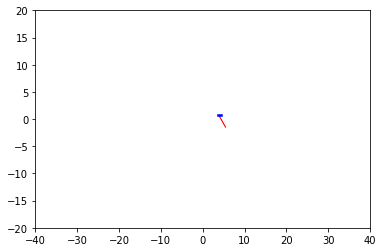

In [13]:
params = {}
params['pole_l'] = 2.5
params['pole_w'] = 0.1
params['cart_w'] = 1.
params['cart_h'] = 0.5
params['obs_w'] = 4
params['obs_h'] = 4
params['integration_step'] = 0.002
obs_list = []
system = CartPole(obs_list)
vis = CartPoleVisualizer(system, params)
status, states, actions, times = solution
anim = vis.animate(states, actions, times, obs_list)
HTML(anim.to_html5_video())

In [ ]:
print(obs_list)